In [1]:
from load_data import ChestXrayDataSet
import numpy as np
import tensorflow as tf
import prettytensor as pt
import os
import time

/home/anas/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.__version__

'1.7.0'

In [3]:
N_CLASSES = 2
DATA_DIR = 'images/'
TRAIN_IMAGE_LIST = 'training0.txt'
TEST_IMAGE_LIST = 'test0.txt'
BATCH_SIZE = 64

IMG_SIZE=128

In [4]:
train_dataset = ChestXrayDataSet(data_dir=DATA_DIR,
                                    image_list_file=TRAIN_IMAGE_LIST,IMG_SIZE=IMG_SIZE)

In [5]:
test=ChestXrayDataSet(data_dir=DATA_DIR,
                                    image_list_file=TEST_IMAGE_LIST,IMG_SIZE=IMG_SIZE)

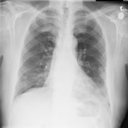

In [6]:
train_dataset[3][0]

In [7]:
train_dataset[3][1]

[1, 0]

In [8]:
x = tf.placeholder(tf.float32, shape=[None, IMG_SIZE, IMG_SIZE, 3], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, N_CLASSES], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

In [9]:
def main_network(images, training):
    # Wrap the input images as a Pretty Tensor object.
    x_pretty = pt.wrap(images)

    # Pretty Tensor uses special numbers to distinguish between
    # the training and testing phases.
    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer

    # Create the convolutional neural network using Pretty Tensor.
    # It is very similar to the previous tutorials, except
    # the use of so-called batch-normalization in the first layer.
    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=64, name='layer_conv1', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=3, depth=64, name='layer_conv2', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=256, name='layer_fc2').\
            fully_connected(size=128, name='layer_fc3').\
            softmax_classifier(num_classes=N_CLASSES, labels=y_true)

    return y_pred, loss

In [10]:
def create_network(training):
    # Wrap the neural network in the scope named 'network'.
    # Create new variables during training, and re-use during testing.
    with tf.variable_scope('network', reuse=not training):
        # Just rename the input placeholder variable for convenience.
        images = x


        # Create TensorFlow graph for the main processing.
        y_pred, loss = main_network(images=images, training=training)

    return y_pred, loss

In [11]:
global_step = tf.Variable(initial_value=0,name='global_step', trainable=False)

In [12]:
_, loss = create_network(training=True)

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [13]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss,global_step=global_step)

### Create Neural Network for Test Phase / Inference


In [14]:
y_pred, _ = create_network(training=False)

In [15]:
y_pred_cls = tf.argmax(y_pred, axis=1)

In [16]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [17]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Saver

In [18]:
saver = tf.train.Saver()

### TensorFlow

In [19]:
session = tf.Session()
save_dir = 'checkpoints/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, 'cheXnet')

In [20]:
try:
    print("Trying to restore last checkpoint ...")

    # Use TensorFlow to find the latest checkpoint - if any.
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
except:
    # If the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph.
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())

Trying to restore last checkpoint ...
INFO:tensorflow:Restoring parameters from checkpoints/cheXnet-36000
('Restored checkpoint from:', u'checkpoints/cheXnet-36000')


In [21]:
def random_batch():
    # Number of images in the training-set.
    num_images = len(train_dataset)

    # Create a random index.
    idx = np.random.choice(num_images,size=BATCH_SIZE,replace=False)

    # Use the random index to select random images and labels.7
    x_batch=[]
    y_batch=[]
    for i in idx:
        x_batch.append(np.array(train_dataset[i][0]))
        y_batch.append(train_dataset[i][1])

    return x_batch, y_batch

In [22]:
def optimize(num_iterations):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch()
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,y_true: y_true_batch}
        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        # We also want to retrieve the global_step counter.
        i_global, _ = session.run([global_step, optimizer],feed_dict=feed_dict_train)
        # Print status to screen every 100 iterations (and last).
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            # Calculate the accuracy on the training-batch.
            batch_acc = session.run(accuracy,feed_dict=feed_dict_train)
            # Print status.
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))

        # Save a checkpoint to disk every 1000 iterations (and last).
        if (i_global % 1000 == 0) or (i == num_iterations - 1):
            # Save all variables of the TensorFlow graph to a
            # checkpoint. Append the global_step counter
            # to the filename so we save the last several checkpoints.
            saver.save(session,
                       save_path=save_path,
                       global_step=global_step)

            print("Saved checkpoint.")

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [23]:
batch_size = 64

def predict_cls(test):
    # Number of images.
    num_images = len(test)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0
    testLabels=[]
    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        testImages=[]
        
        for l in range(i,j):
            testImages.append(np.array(test[l][0]));
            testLabels.append(test[l][1])
        feed_dict = {x: testImages,y_true: testLabels}
        
        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Create a boolean array whether each image is correctly classified.
    correct=0
    for i in range(len(cls_pred)):
        if(cls_pred[i]==testLabels[i][1]):
            correct=correct+1
            
    return correct, cls_pred

def predict_cls_test():
    return predict_cls(test=test)


In [ ]:
def print_test_accuracy():

    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls_test()
    
    # Classification accuracy and the number of correct classifications.
    # Number of images being classified.

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(((correct*100.0)/len(cls_pred)), correct, len(cls_pred)))
    print(cls_pred)

In [ ]:
if True:
   optimize(num_iterations=200000)

Global Step:  36100, Training Batch Accuracy:  95.3%
Global Step:  36200, Training Batch Accuracy:  93.8%
Global Step:  36300, Training Batch Accuracy: 100.0%
Global Step:  36400, Training Batch Accuracy: 100.0%
Global Step:  36500, Training Batch Accuracy:  98.4%
Global Step:  36600, Training Batch Accuracy:  96.9%
Global Step:  36700, Training Batch Accuracy:  96.9%
Global Step:  36800, Training Batch Accuracy:  98.4%
Global Step:  36900, Training Batch Accuracy:  95.3%
Global Step:  37000, Training Batch Accuracy:  98.4%
Saved checkpoint.
Global Step:  37100, Training Batch Accuracy:  95.3%
Global Step:  37200, Training Batch Accuracy:  93.8%
Global Step:  37300, Training Batch Accuracy:  98.4%
Global Step:  37400, Training Batch Accuracy:  95.3%
Global Step:  37500, Training Batch Accuracy:  96.9%
Global Step:  37600, Training Batch Accuracy:  96.9%
Global Step:  37700, Training Batch Accuracy:  98.4%
Global Step:  37800, Training Batch Accuracy: 100.0%
Global Step:  37900, Trainin

In [ ]:
print_test_accuracy()